In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from math import pi
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import NearestNeighbors

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv('online_retail_II.csv')
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS      12.0   
1  489434    79323P                   PINK CHERRY LIGHTS      12.0   
2  489434    79323W                  WHITE CHERRY LIGHTS      12.0   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE       48.0   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX      24.0   

        InvoiceDate  Price  Customer ID         Country  
0  01/12/2009 07:45   6.95      13085.0  United Kingdom  
1  01/12/2009 07:45   6.75      13085.0  United Kingdom  
2  01/12/2009 07:45   6.75      13085.0  United Kingdom  
3  01/12/2009 07:45   2.10      13085.0  United Kingdom  
4  01/12/2009 07:45   1.25      13085.0  United Kingdom

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067372 entries, 0 to 1067371
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067372 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  float64
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(3), object(5)
memory usage: 65.1+ MB


In [4]:
df.describe().T

count          mean          std       min       25%  \
Quantity     1067371.0      9.938898   172.705794 -80995.00      1.00   
Price        1067371.0      4.649388   123.553059 -53594.36      1.25   
Customer ID   824364.0  15324.638504  1697.464450  12346.00  13975.00   

                 50%       75%      max  
Quantity         3.0     10.00  80995.0  
Price            2.1      4.15  38970.0  
Customer ID  15255.0  16797.00  18287.0

In [5]:
df.describe(include="object").T

count unique                                 top    freq
Invoice      1067372  53630                              537434    1350
StockCode    1067371   5305                              85123A    5829
Description  1062989   5698  WHITE HANGING HEART T-LIGHT HOLDER    5918
InvoiceDate  1067371  47635                    06/12/2010 16:57    1350
Country      1067371     43                      United Kingdom  981330

In [6]:
null_percentage= df.isnull().sum()*100 / len(df)
print('The total percentage of missing values in each column is: \n')
for column, percentage in null_percentage.items():
    print(f'{column}: {percentage:.2f}%')

The total percentage of missing values in each column is: 

Invoice: 0.00%
StockCode: 0.00%
Description: 0.41%
Quantity: 0.00%
InvoiceDate: 0.00%
Price: 0.00%
Customer ID: 22.77%
Country: 0.00%


<Axes: >

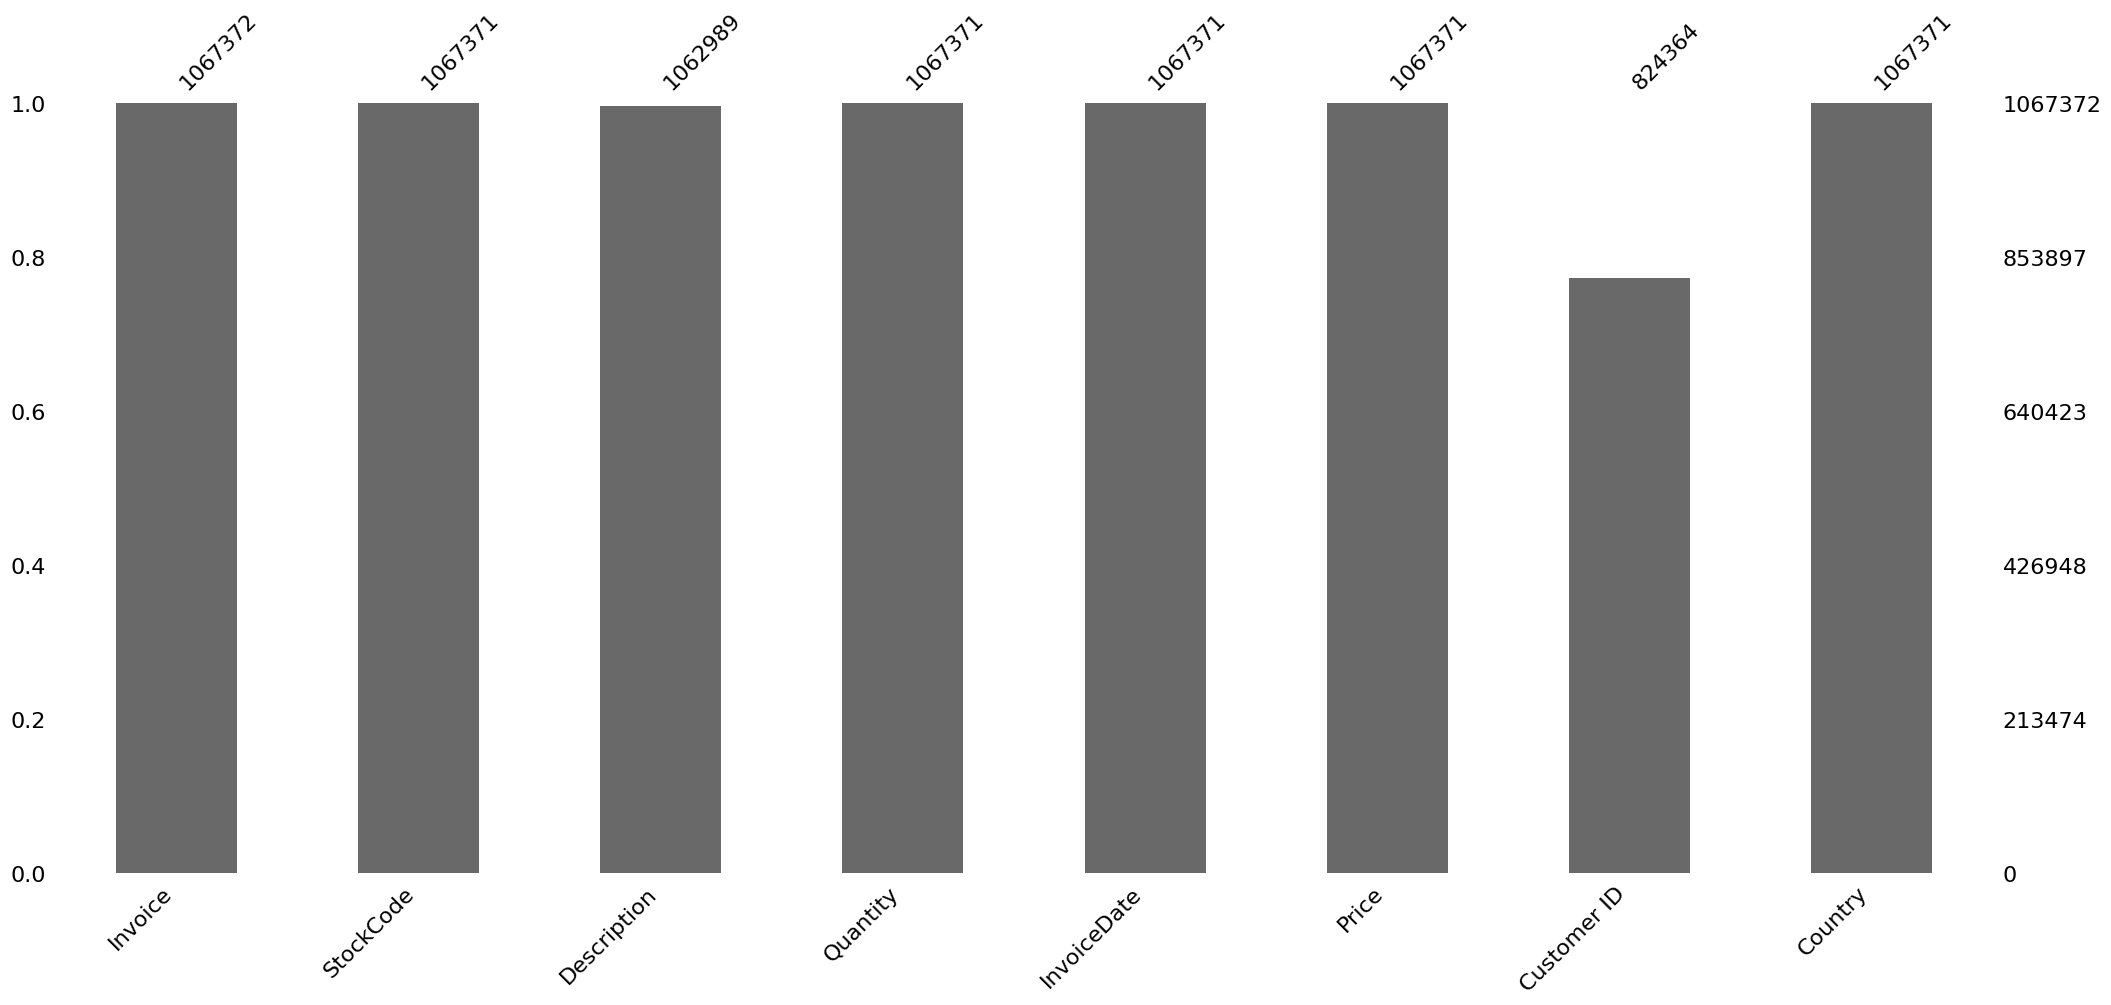

In [7]:
msno.bar(df)

In [8]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['Invoice', 'StockCode', 'Description', 'Customer ID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

Invoice StockCode                       Description  Quantity  \
379  489517     21491   SET OF THREE VINTAGE GIFT WRAPS       1.0   
391  489517     21491   SET OF THREE VINTAGE GIFT WRAPS       1.0   
365  489517     21821  GLITTER STAR GARLAND WITH BELLS        1.0   
386  489517     21821  GLITTER STAR GARLAND WITH BELLS        1.0   
363  489517     21912          VINTAGE SNAKES & LADDERS       1.0   
371  489517     21912          VINTAGE SNAKES & LADDERS       1.0   
394  489517     21912          VINTAGE SNAKES & LADDERS       1.0   
362  489517     21913    VINTAGE SEASIDE JIGSAW PUZZLES       1.0   
385  489517     21913    VINTAGE SEASIDE JIGSAW PUZZLES       1.0   
368  489517     22130  PARTY CONE CHRISTMAS DECORATION        6.0   

          InvoiceDate  Price  Customer ID         Country  
379  01/12/2009 11:34   1.95      16329.0  United Kingdom  
391  01/12/2009 11:34   1.95      16329.0  United Kingdom  
365  01/12/2009 11:34   3.75      16329.0  United Kingdom  
386  01/12/2009 11:34   3.75      16329.0  United Kingdom  
363  01/12/2009 11:34   3.75      16329.0  United Kingdom  
371  01/12/2009 11:34   3.75      16329.0  United Kingdom  
394  01/12/2009 11:34   3.75      16329.0  United Kingdom  
362  01/12/2009 11:34   3.75      16329.0  United Kingdom  
385  01/12/2009 11:34   3.75      16329.0  United Kingdom  
368  01/12/2009 11:34   0.85      16329.0  United Kingdom

In [9]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 34334 duplicate rows that need to be removed.


In [10]:
df.shape[0]

1033038

In [11]:
df_clean = df.dropna()
df_clean = df_clean[df_clean['Price'] != 0.0]
# df_clean = df_clean[~df_clean['Invoice'].str.startswith('C', na=False)]
df_clean.shape

(797816, 8)

In [12]:
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], format='%d/%m/%Y %H:%M',errors='coerce')

print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 797816 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      797816 non-null  object        
 1   StockCode    797816 non-null  object        
 2   Description  797816 non-null  object        
 3   Quantity     797816 non-null  float64       
 4   InvoiceDate  797816 non-null  datetime64[ns]
 5   Price        797816 non-null  float64       
 6   Customer ID  797816 non-null  float64       
 7   Country      797816 non-null  object        
 8   TotalAmount  797816 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 60.9+ MB
None


In [13]:
df_clean['Transaction_Status'] = np.where(df_clean['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
cancellations = df_clean[df_clean['Transaction_Status'] == 'Cancelled']
cancellation_percentage = (cancellations.shape[0] / df_clean.shape[0]) * 100

print(f"{cancellation_percentage:.2f}% of the transcations were cancelled in the dataset.")

2.31% of the transcations were cancelled in the dataset.


In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Lets have a look at 'Country' feature in the dataset

## Lets have a look at the feature 'Description' in the dataset and identify any inconsitency or anomalies present in this feature.

In [17]:
print("Top 10 categories in the feature Description:\n", df_clean["Description"].value_counts().head(10), "\n")

Top 10 categories in the feature Description:
 Description
WHITE HANGING HEART T-LIGHT HOLDER    5150
REGENCY CAKESTAND 3 TIER              3676
JUMBO BAG RED RETROSPOT               2713
ASSORTED COLOUR BIRD ORNAMENT         2709
PARTY BUNTING                         2120
LUNCH BAG  BLACK SKULL.               2089
STRAWBERRY CERAMIC TRINKET BOX        2040
POSTAGE                               1983
BAKING SET 9 PIECE RETROSPOT          1961
REX CASH+CARRY JUMBO SHOPPER          1959
Name: count, dtype: int64 



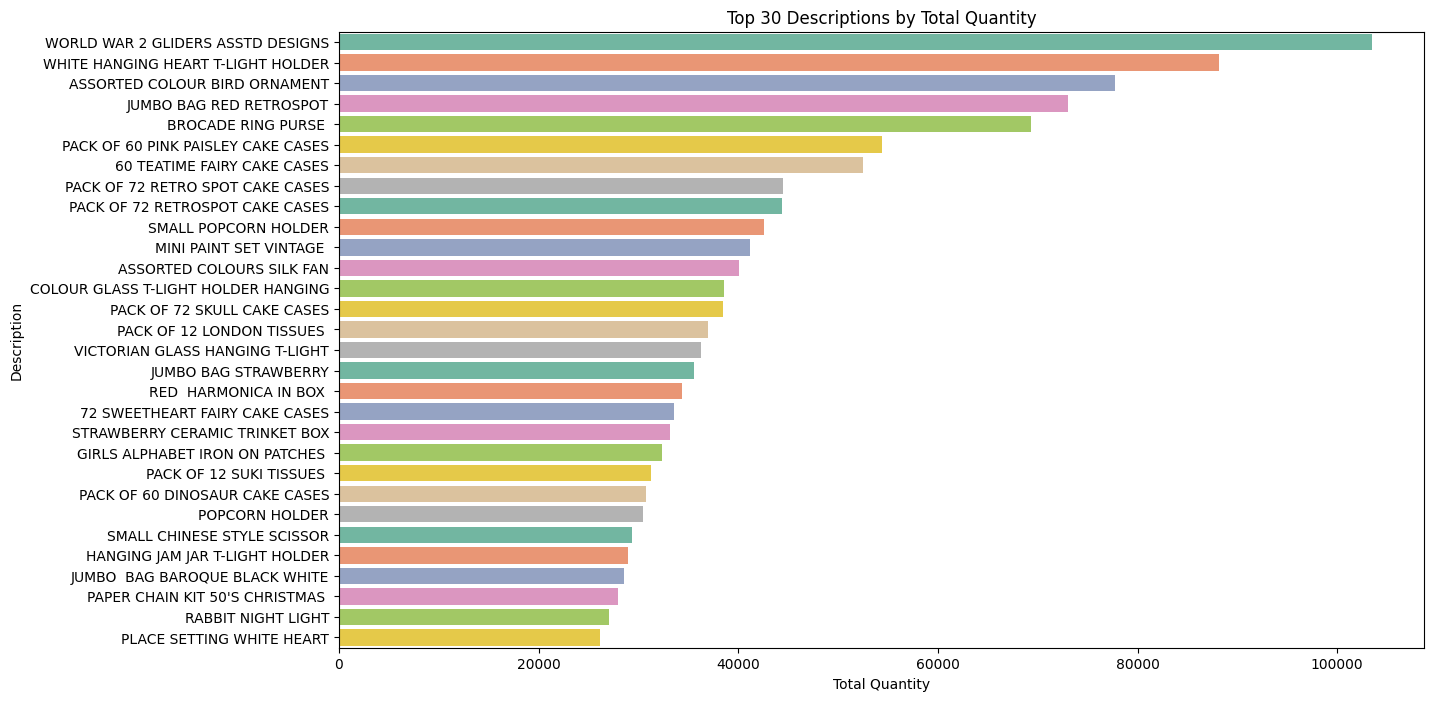

In [18]:
plt.figure(figsize=(14, 8))
top_descriptions = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(30)
sns.barplot(x=top_descriptions.values, y=top_descriptions.index, palette='Set2',legend='false')
plt.title('Top 30 Descriptions by Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Description')
plt.show()

**<p> We can see that there are two descriptions with same names with only a space in between **'RETROSPOT AND RETRO SPOT'**. Therefore we combine these together.<br> 
We will also check if there are any lowercase letters to check for consistency in the dataset.</p>**

In [20]:
# Combining the same name entries by removing the space in between

df_clean["Description"] = df_clean["Description"].str.replace('PACK OF 72 RETRO SPOT CAKE CASES', 'PACK OF 72 RETROSPOT CAKE CASES')

contains_lowercase = df_clean["Description"].str.contains('[a-z]')
lowercase_rows = df_clean[contains_lowercase]["Description"].value_counts()
print("Rows with lowercase letters in the Description column:\n", lowercase_rows)

Rows with lowercase letters in the Description column:
 Description
Manual                                 1078
BAG 250g SWIRLY MARBLES                 477
BAG 125g SWIRLY MARBLES                 474
POLYESTER FILLER PAD 40x40cm            374
POLYESTER FILLER PAD 45x45cm            345
3 TRADITIONAl BISCUIT CUTTERS  SET      223
BAG 500g SWIRLY MARBLES                 191
Discount                                170
FRENCH BLUE METAL DOOR SIGN No           83
Next Day Carriage                        80
POLYESTER FILLER PAD 45x30cm             59
ESSENTIAL BALM 3.5g TIN IN ENVELOPE      54
POLYESTER FILLER PAD 30CMx30CM           51
POLYESTER FILLER PAD 65CMx65CM           49
Adjustment by john on 26/01/2010 16      36
FRENCH BLUE METAL DOOR SIGN, No          35
Bank Charges                             34
FOLK ART GREETING CARD,pack/12           25
Adjustment by john on 26/01/2010 17      22
CRUK Commission                          16
This is a test product.                  14
NUMBER T

**Upon revewing the descriptions above we can see that some entries like Manual, Discount, Next day carriage, bank charges, test product, postage and high resoulution image are unrelated to the actual product. So we remove these features along with POSTAGE.**

In [22]:
descriptions_to_delete = ["Manual", "Discount", "This is a test product.", " Bank Charges", "High Resolution Image", "CRUK Commission", "Next Day Carriage" ]

to_delete_percentage =  df_clean[df_clean['Description'].isin(descriptions_to_delete)].shape[0] / df.shape[0] * 100
print(f"The percentage of records with service-related descriptions in the dataset is: {to_delete_percentage:.2f}%")

df_clean = df_clean[~df_clean["Description"].isin(descriptions_to_delete)]

The percentage of records with service-related descriptions in the dataset is: 0.13%


In [23]:
print(f'The total number of rows in the dataframe after cleaning descriptions feature is {df_clean.shape[0]}.')

The total number of rows in the dataframe after cleaning descriptions feature is 796452.


## Now,lets have a look at 'StockCodes' to check for any inconsistency in the data.

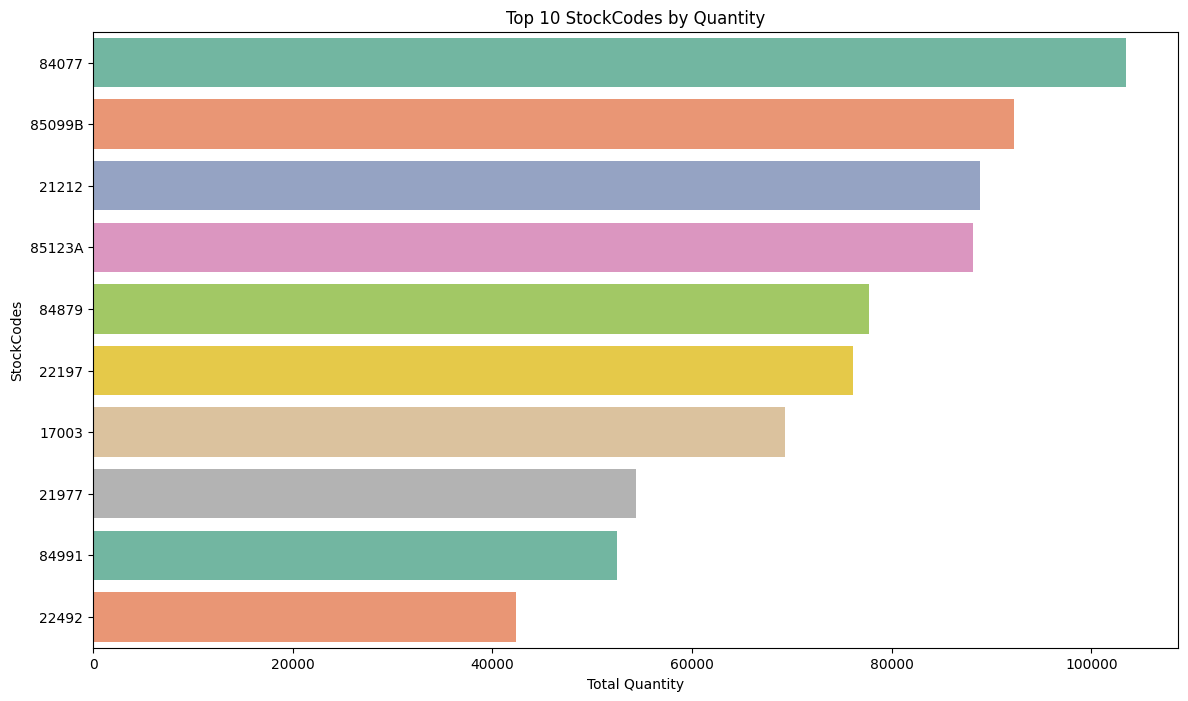

In [25]:
plt.figure(figsize=(14, 8))
top_descriptions = df_clean.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_descriptions.values, y=top_descriptions.index, palette='Set2')
plt.title('Top 10 StockCodes by Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('StockCodes')
plt.show()

**Upon looking at the graph, it can be seen that some of the stock codes contain alphabet while others don't.**

In [27]:
stock_codes= df['StockCode'].unique()
stock_codes_type = pd.Series(stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
print(stock_codes_type)

5    5243
4      31
0      18
6       9
1       3
3       2
Name: count, dtype: int64


In [28]:
irregular_stock_codes = [code for code in stock_codes if sum(c.isdigit() for c in str(code)) <= 4]

# Printing each stock code on a new line
print("Irregular stock codes:")
print("-"*22)
for code in irregular_stock_codes:
    print(code)
    
percentage_irregular =(len(irregular_stock_codes)/len(df['StockCode']) )* 100
print(f'Total percentage of irregular stock codes is {percentage_irregular: .2f}%.')
                       

Irregular stock codes:
----------------------
POST
D
DCGS0058
DCGS0068
DOT
M
DCGS0004
DCGS0076
C2
BANK CHARGES
DCGS0003
TEST001
DCGS0072
DCGS0044
TEST002
DCGS0066N
PADS
ADJUST
DCGSSGIRL
DCGS0006
DCGS0016
DCGS0027
DCGS0036
DCGS0039
DCGS0060
DCGS0056
DCGS0059
GIFT
DCGSLBOY
m
DCGS0053
DCGS0062
DCGS0037
DCGSSBOY
DCGSLGIRL
S
DCGS0069
DCGS0070
DCGS0075
B
DCGS0041
ADJUST2
C3
SP1002
AMAZONFEE
DCGS0055
DCGS0074
DCGS0057
DCGS0073
DCGS0071
DCGS0066P
DCGS0067
CRUK
nan
Total percentage of irregular stock codes is  0.01%.


In [29]:
df_clean = df_clean[~df_clean['StockCode'].isin(irregular_stock_codes)]

In [30]:
print(f'The total number of rows after removing irrgular stock code is {df_clean.shape[0]}.')

The total number of rows after removing irrgular stock code is 794081.


In [31]:
df_clean.reset_index(drop=True, inplace=True)

In [32]:
df_clean.shape[0]

794081

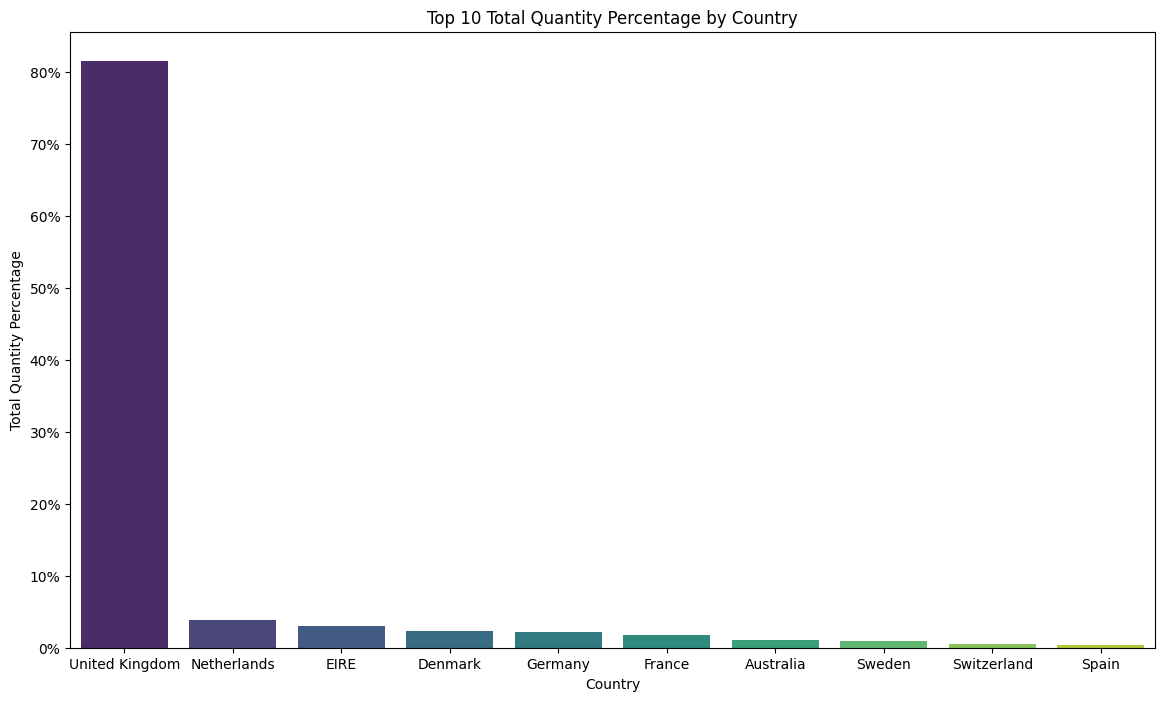

In [33]:
plt.figure(figsize=(14, 8))
country_quantity = df_clean.groupby('Country')['Quantity'].sum().pipe(lambda x: (x / x.sum()) * 100).sort_values(ascending=False).head(10)
sns.barplot(x=country_quantity.index, y=country_quantity.values, palette='viridis', legend = 'False')
plt.title('Top 10 Total Quantity Percentage by Country')
plt.xlabel('Country')
plt.ylabel('Total Quantity Percentage')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.show()

United Kingdom is the top country over 80% of the total quantity purchased.

## Feature Engineering

#### RFM values calculation

In [37]:
latest_date = df_clean['InvoiceDate'].max().strftime('%Y-%m-%d')
oldest_date = df_clean['InvoiceDate'].min().strftime('%Y-%m-%d')
print(f'The latest transaction date was on: {latest_date}')
print(f'The oldest transaction date was on: {oldest_date}')

The latest transaction date was on: 2011-12-09
The oldest transaction date was on: 2009-12-01


In [38]:
ref_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

data_rfm = df_clean.groupby(['Customer ID']).agg({
    'InvoiceDate': [
        lambda x: (ref_date - x.max()).days,  # Recency: days since last purchase
        lambda x: (ref_date - x.min()).days   # Days Since First Purchase
    ], 
    'Invoice': 'count',  
    'TotalAmount': 'sum',
    # 'Country': 'first',
    # 'Quantity': 'sum',
}).reset_index()

# data_rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalAmount': 'MonetaryValue'}, inplace=True)
data_rfm.columns = ['Customer ID', 'Recency', 'DaysSinceFirstPurchase', 'Frequency', 'MonetaryValue']
data_rfm = data_rfm[['Customer ID', 'Recency', 'Frequency', 'MonetaryValue', 'DaysSinceFirstPurchase']]

data_rfm.describe()


Customer ID      Recency     Frequency  MonetaryValue  \
count   5875.000000  5875.000000   5875.000000    5875.000000   
mean   15321.350128   199.482383    135.162723    2784.241334   
std     1714.611499   209.382117    347.768519   13799.305992   
min    12346.000000     1.000000      1.000000   -1343.240000   
25%    13839.500000    24.500000     21.000000     327.800000   
50%    15322.000000    94.000000     53.000000     835.220000   
75%    16804.500000   378.000000    140.000000    2164.280000   
max    18287.000000   739.000000  12622.000000  578408.640000   

       DaysSinceFirstPurchase  
count             5875.000000  
mean               476.803404  
std                224.318926  
min                  1.000000  
25%                316.000000  
50%                534.000000  
75%                673.000000  
max                739.000000

<Axes: xlabel='MonetaryValue', ylabel='Density'>

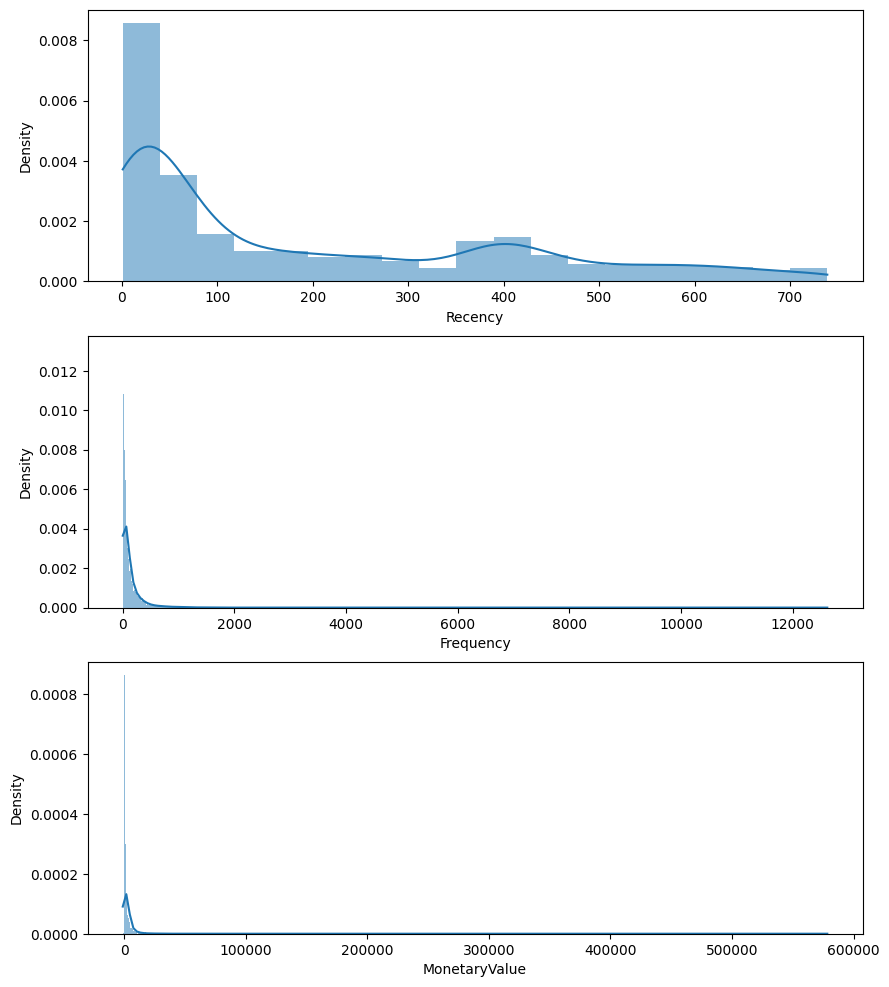

In [39]:
plt.figure(figsize=(10, 12))

# Plot distribution of Recency
plt.subplot(3, 1, 1); sns.histplot(data_rfm['Recency'], kde=True, stat="density", linewidth=0)

# Plot distribution of Frequency
plt.subplot(3, 1, 2); sns.histplot(data_rfm['Frequency'], kde=True, stat="density", linewidth=0)

# Plot distribution of MonetaryValue
plt.subplot(3, 1, 3); sns.histplot(data_rfm['MonetaryValue'], kde=True, stat="density", linewidth=0)

From the histograms above, the RFM feature are highly right skewed.

#### Adding additional Features

* **Average Transaction Value**

In [43]:
avg_transaction_value = df_clean.groupby('Customer ID')['TotalAmount'].mean()
avg_transaction_value.name = 'AvgTransactionValue'

data_rfm = data_rfm.merge(avg_transaction_value, on='Customer ID', how='left')
data_rfm.head()

Customer ID  Recency  Frequency  MonetaryValue  DaysSinceFirstPurchase  \
0      12346.0      326         26         169.36                     647   
1      12347.0        2        222        4921.53                     404   
2      12348.0       75         46        1658.40                     438   
3      12349.0       19        177        3654.54                     736   
4      12350.0      310         16         294.40                     310   

   AvgTransactionValue  
0             6.513846  
1            22.169054  
2            36.052174  
3            20.647119  
4            18.400000

In [44]:
df_clean['DaysBetweenPurchases'] = df_clean.groupby('Customer ID')['InvoiceDate'].diff().dt.days

In [45]:
avg_days_between_purchases = df_clean.groupby('Customer ID')['DaysBetweenPurchases'].mean()
avg_days_between_purchases.name = 'AvgDaysBetweenPurchases'
data_rfm = data_rfm.merge(avg_days_between_purchases, on='Customer ID', how='left')
data_rfm.head()

Customer ID  Recency  Frequency  MonetaryValue  DaysSinceFirstPurchase  \
0      12346.0      326         26         169.36                     647   
1      12347.0        2        222        4921.53                     404   
2      12348.0       75         46        1658.40                     438   
3      12349.0       19        177        3654.54                     736   
4      12350.0      310         16         294.40                     310   

   AvgTransactionValue  AvgDaysBetweenPurchases  
0             6.513846                12.840000  
1            22.169054                 1.805430  
2            36.052174                 8.044444  
3            20.647119                 4.068182  
4            18.400000                 0.000000

* **Unique Products Purchased**

In [47]:
unique_products_purchased = df_clean.groupby('Customer ID')['StockCode'].nunique()
unique_products_purchased.name = 'UniqueProductsPurchased'

data_rfm = data_rfm.merge(unique_products_purchased, on='Customer ID', how='left')
data_rfm.head()

Customer ID  Recency  Frequency  MonetaryValue  DaysSinceFirstPurchase  \
0      12346.0      326         26         169.36                     647   
1      12347.0        2        222        4921.53                     404   
2      12348.0       75         46        1658.40                     438   
3      12349.0       19        177        3654.54                     736   
4      12350.0      310         16         294.40                     310   

   AvgTransactionValue  AvgDaysBetweenPurchases  UniqueProductsPurchased  
0             6.513846                12.840000                       25  
1            22.169054                 1.805430                      126  
2            36.052174                 8.044444                       24  
3            20.647119                 4.068182                      138  
4            18.400000                 0.000000                       16

In [48]:
cancellations = df_clean[df_clean['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancellations.groupby('Customer ID').size().reset_index(name='CancellationFrequency')

all_customers = df_clean['Customer ID'].unique()
cancellation_frequency_all = pd.DataFrame(all_customers, columns=['Customer ID']).merge(cancellation_frequency, on='Customer ID', how='left')
cancellation_frequency_all['CancellationFrequency'].fillna(0, inplace=True)

data_rfm = data_rfm.merge(cancellation_frequency_all, on='Customer ID', how='left')
data_rfm.head()

Customer ID  Recency  Frequency  MonetaryValue  DaysSinceFirstPurchase  \
0      12346.0      326         26         169.36                     647   
1      12347.0        2        222        4921.53                     404   
2      12348.0       75         46        1658.40                     438   
3      12349.0       19        177        3654.54                     736   
4      12350.0      310         16         294.40                     310   

   AvgTransactionValue  AvgDaysBetweenPurchases  UniqueProductsPurchased  \
0             6.513846                12.840000                       25   
1            22.169054                 1.805430                      126   
2            36.052174                 8.044444                       24   
3            20.647119                 4.068182                      138   
4            18.400000                 0.000000                       16   

   CancellationFrequency  
0                    1.0  
1                    0.0  
2                    0.0  
3                    5.0  
4                    0.0

In [49]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer ID              5875 non-null   float64
 1   Recency                  5875 non-null   int64  
 2   Frequency                5875 non-null   int64  
 3   MonetaryValue            5875 non-null   float64
 4   DaysSinceFirstPurchase   5875 non-null   int64  
 5   AvgTransactionValue      5875 non-null   float64
 6   AvgDaysBetweenPurchases  5767 non-null   float64
 7   UniqueProductsPurchased  5875 non-null   int64  
 8   CancellationFrequency    5875 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 413.2 KB


In [50]:
data_rfm.describe()

Customer ID      Recency     Frequency  MonetaryValue  \
count   5875.000000  5875.000000   5875.000000    5875.000000   
mean   15321.350128   199.482383    135.162723    2784.241334   
std     1714.611499   209.382117    347.768519   13799.305992   
min    12346.000000     1.000000      1.000000   -1343.240000   
25%    13839.500000    24.500000     21.000000     327.800000   
50%    15322.000000    94.000000     53.000000     835.220000   
75%    16804.500000   378.000000    140.000000    2164.280000   
max    18287.000000   739.000000  12622.000000  578408.640000   

       DaysSinceFirstPurchase  AvgTransactionValue  AvgDaysBetweenPurchases  \
count             5875.000000          5875.000000              5767.000000   
mean               476.803404            30.429484                 5.310962   
std                224.318926           156.800469                18.499398   
min                  1.000000           -54.000000                 0.000000   
25%                316.000000            10.717324                 0.100459   
50%                534.000000            16.436000                 1.974138   
75%                673.000000            22.496026                 4.893946   
max                739.000000          9904.875000               596.000000   

       UniqueProductsPurchased  CancellationFrequency  
count              5875.000000            5875.000000  
mean                 82.021617               2.993191  
std                 116.570368              10.879315  
min                   1.000000               0.000000  
25%                  19.000000               0.000000  
50%                  45.000000               0.000000  
75%                 103.000000               2.000000  
max                2551.000000             343.000000

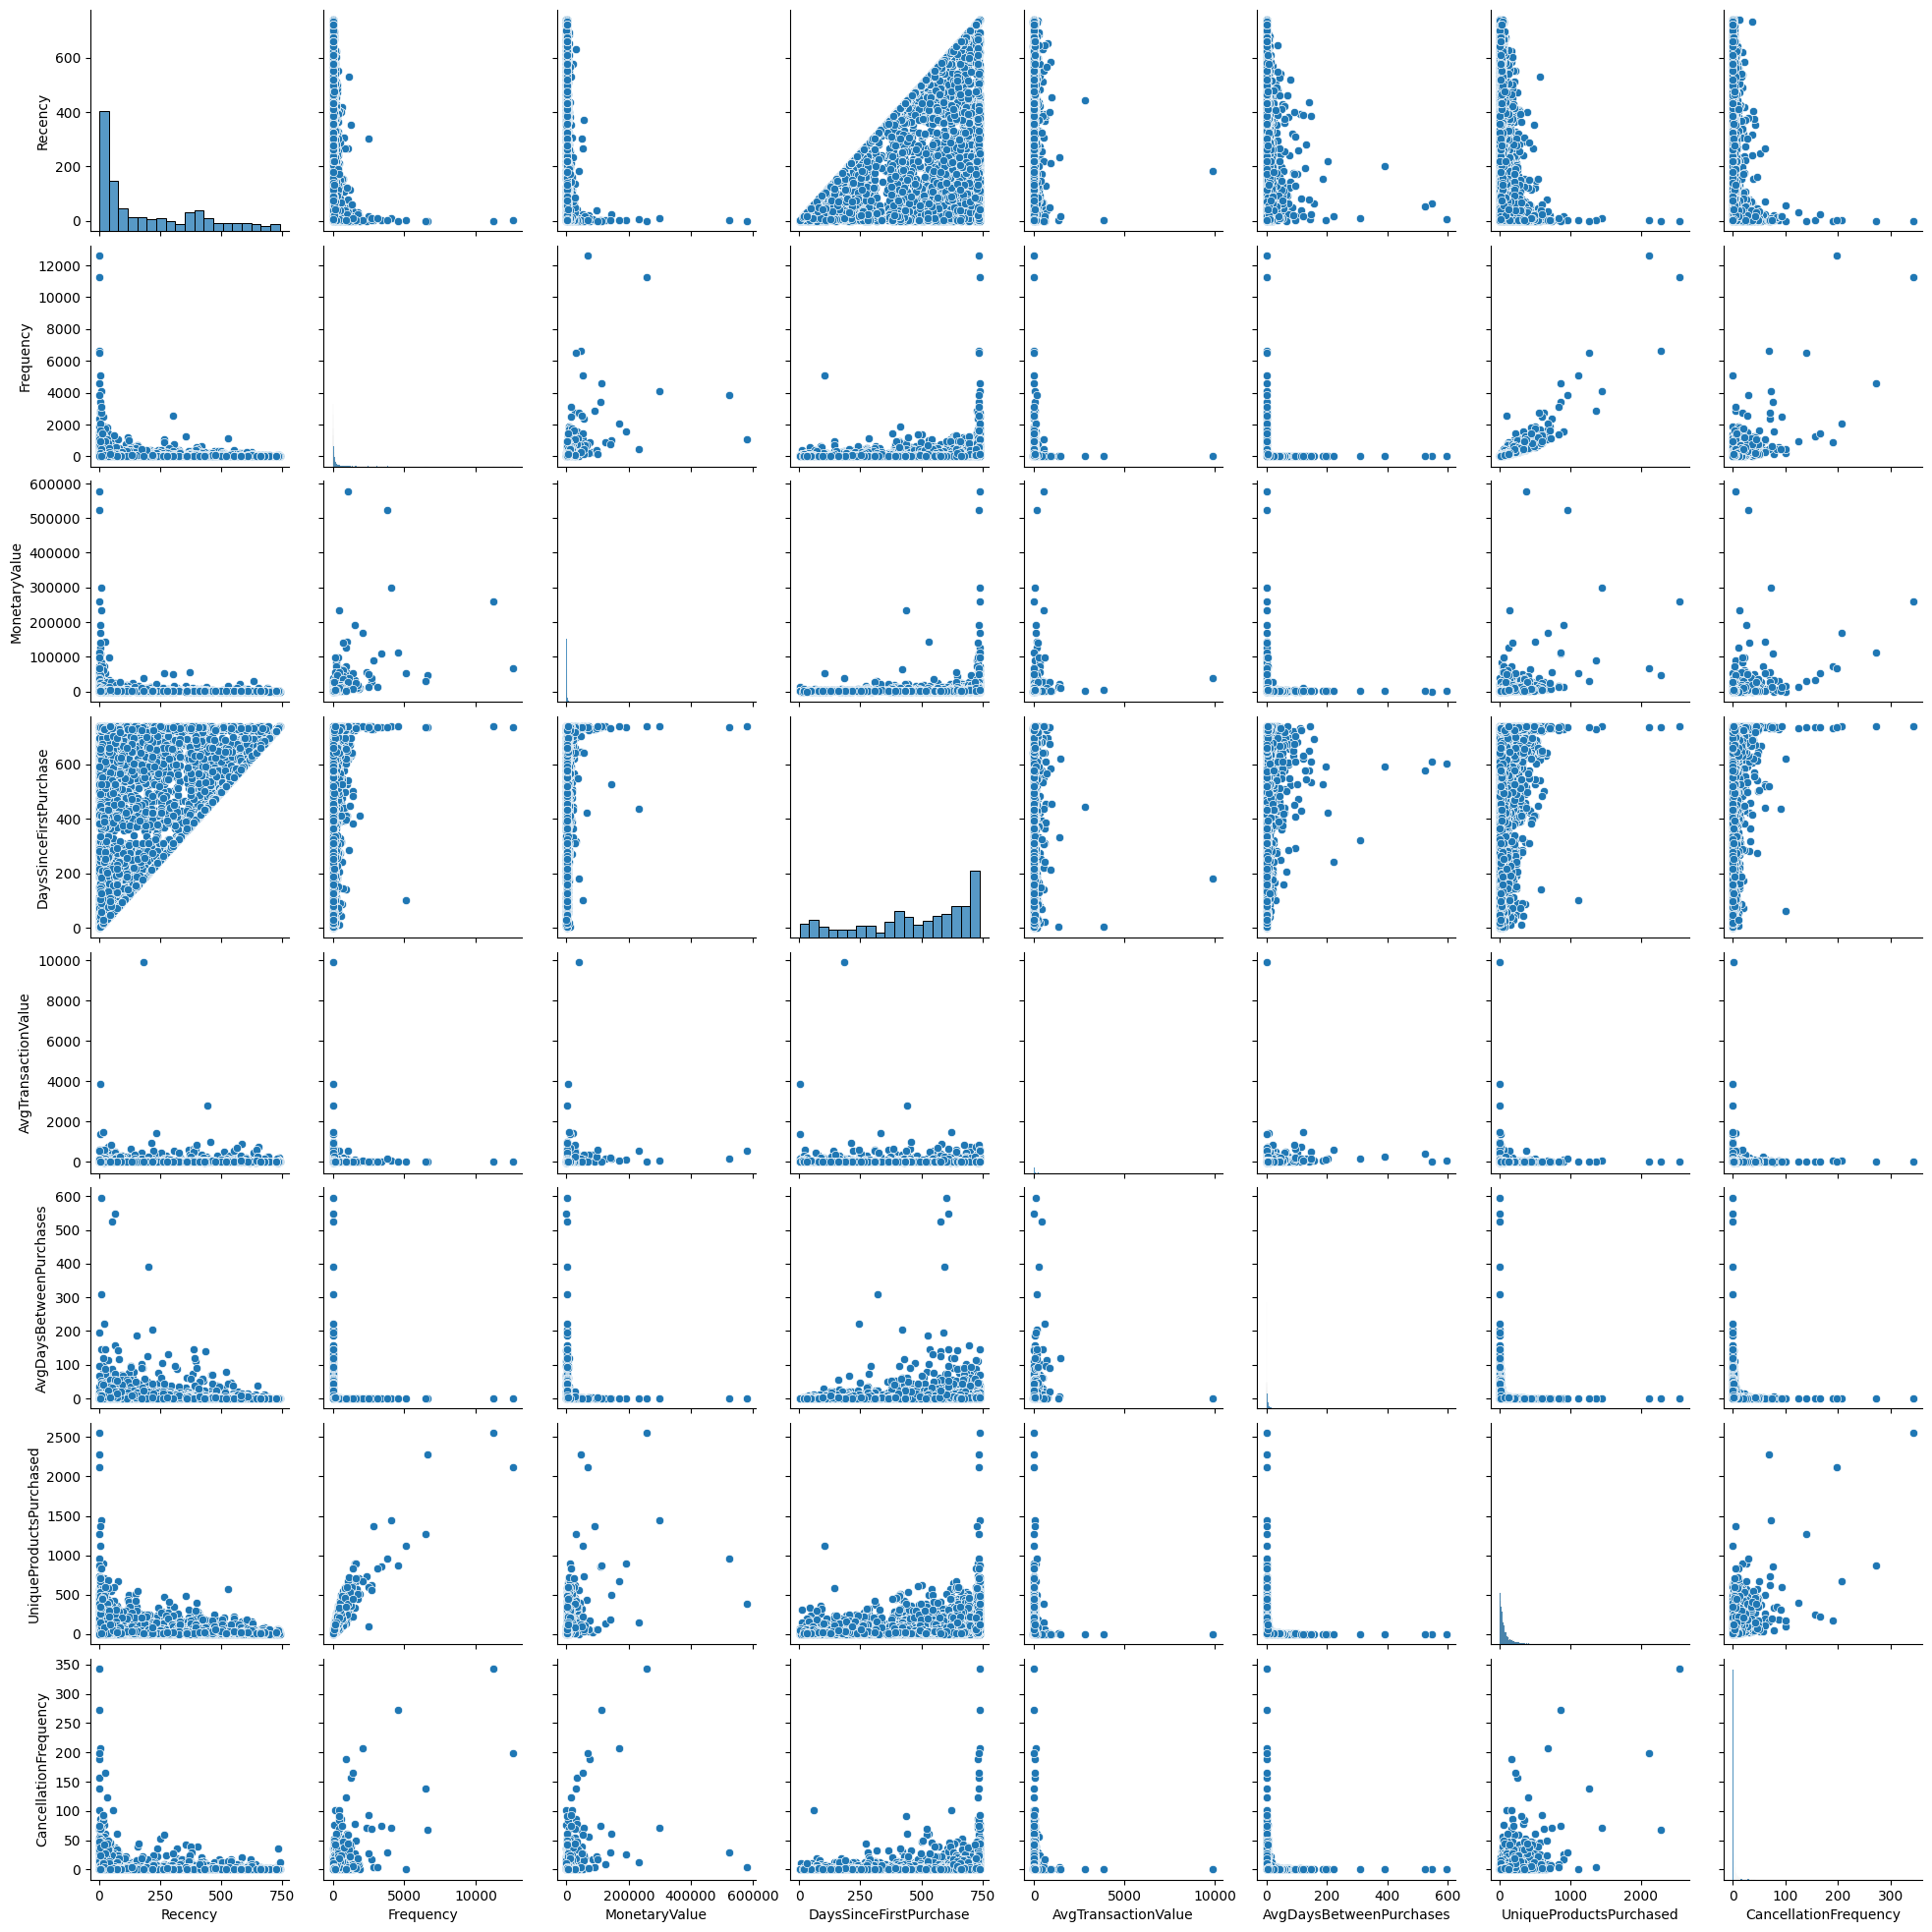

In [51]:
sns.pairplot(data_rfm[['Recency', 'Frequency', 'MonetaryValue', 
                       'DaysSinceFirstPurchase', 'AvgTransactionValue', 
                       'AvgDaysBetweenPurchases', 'UniqueProductsPurchased', 
                       'CancellationFrequency']])
plt.show()


In [52]:
# rfm_log.describe()
# data_rfm = pd.concat([data_rfm, rfm_log], axis=1)

## Handling outliers using isolation forest approach

Lets check if there is any nan values before fitting and fill it with a constant 0.

In [55]:
features = ['Recency', 'Frequency', 'MonetaryValue', 'DaysSinceFirstPurchase', 'AvgTransactionValue', 
            'AvgDaysBetweenPurchases', 'UniqueProductsPurchased', 'CancellationFrequency']
print(data_rfm[features].isna().sum())

Recency                      0
Frequency                    0
MonetaryValue                0
DaysSinceFirstPurchase       0
AvgTransactionValue          0
AvgDaysBetweenPurchases    108
UniqueProductsPurchased      0
CancellationFrequency        0
dtype: int64


In [56]:
data_rfm[features] = data_rfm[features].fillna(0)
print(data_rfm[features].isna().sum())

Recency                    0
Frequency                  0
MonetaryValue              0
DaysSinceFirstPurchase     0
AvgTransactionValue        0
AvgDaysBetweenPurchases    0
UniqueProductsPurchased    0
CancellationFrequency      0
dtype: int64


In [57]:

iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination as needed

# 2. Fit the model directly using the specified features
iso_forest.fit(data_rfm[features])

# 3. Predict outliers (-1 indicates an outlier, 1 indicates inlier)
data_rfm['Outlier'] = iso_forest.predict(data_rfm[features])

# 4. Optionally, filter and display the outliers
outliers = data_rfm[data_rfm['Outlier'] == -1]
inliers = data_rfm[data_rfm['Outlier'] == 1]

# Display the outliers
print(f'There are {outliers.shape[0]} outliers in the dataset.')

There are 294 outliers in the dataset.


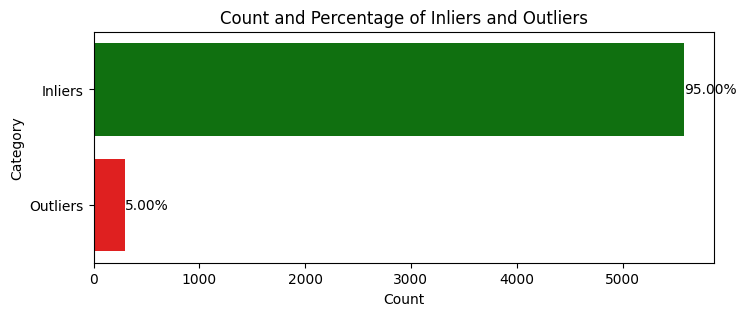

In [58]:
outlier_count = len(outliers)
inlier_count = len(inliers)
total_count = outlier_count + inlier_count

# Calculate the percentages
outlier_percentage = (outlier_count / total_count) * 100
inlier_percentage = (inlier_count / total_count) * 100

# Data for plotting
categories = ['Inliers', 'Outliers']
counts = [inlier_count, outlier_count]
percentages = [inlier_percentage, outlier_percentage]

# Combine counts and categories into a DataFrame for plotting
data_outliers = pd.DataFrame({
    'Category': categories,
    'Count': counts,
    'Percentage': percentages
})

plt.figure(figsize=(8, 3))
# Plotting with Seaborn
sns.barplot(x='Count', y='Category', data=data_outliers, palette=['green', 'red'])

# Add the percentage labels
for index, value in enumerate(data_outliers['Count']):
    plt.text(value, index, f'{data_outliers["Percentage"][index]:.2f}%', va='center')

plt.title('Count and Percentage of Inliers and Outliers')
plt.show()

In [59]:
#Filter outliers in the data
data_rfm = data_rfm[data_rfm['Outlier'] == 1]
data_rfm = data_rfm.drop(columns=['Outlier'])

### Correlation analysis for the data

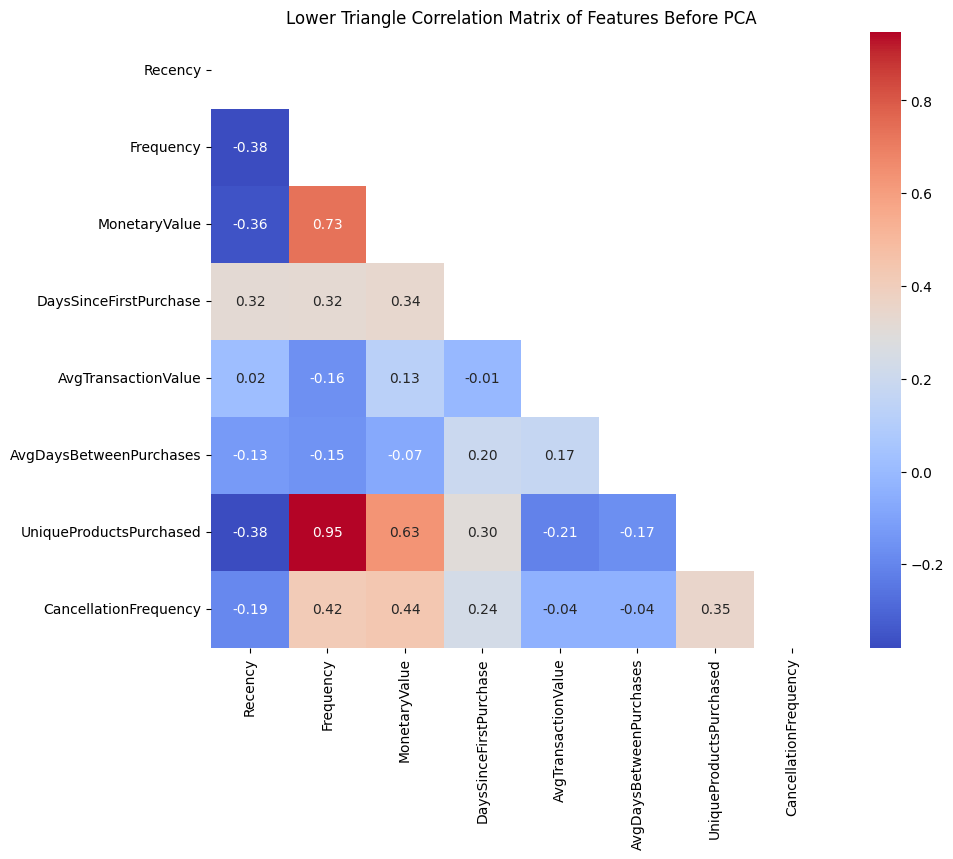

In [61]:
correlation_matrix = data_rfm[features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')
#linewidths=0.5, linecolor='gray',cbar_kws={"shrink": .8}, vmin=-1, vmax=1
plt.title('Lower Triangle Correlation Matrix of Features Before PCA')
plt.show()

**Upon analysing the correlation heatmap between the features, 'Frequency' and 'UniqueProductsPurchased' has the highest correlation among 
features while rest of the features have less correlation.**

### Data Scaling using Standard Scaler

In [64]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_rfm[features]), columns=features)   
data_scaled['Customer ID'] = data_rfm['Customer ID']
data_scaled.head()

Recency  Frequency  MonetaryValue  DaysSinceFirstPurchase  \
0  0.573242  -0.587088      -0.638559                0.789266   
1 -0.968322   0.972842       1.479951               -0.294881   
2 -0.620995  -0.427911       0.025253               -0.143190   
3 -0.887438   0.614695       0.915129                1.186341   
4  0.497116  -0.666676      -0.582816               -0.714263   

   AvgTransactionValue  AvgDaysBetweenPurchases  UniqueProductsPurchased  \
0            -0.563520                 0.903904                -0.601197   
1             0.026115                -0.285520                 0.736148   
2             0.549006                 0.386988                -0.614438   
3            -0.031207                -0.041616                 0.895040   
4            -0.115842                -0.480128                -0.720366   

   CancellationFrequency  Customer ID  
0              -0.214065      12346.0  
1              -0.430691      12347.0  
2              -0.430691      12348.0  
3               0.652442      12349.0  
4              -0.430691      12350.0

In [65]:
data_scaled.set_index('Customer ID', inplace=True)

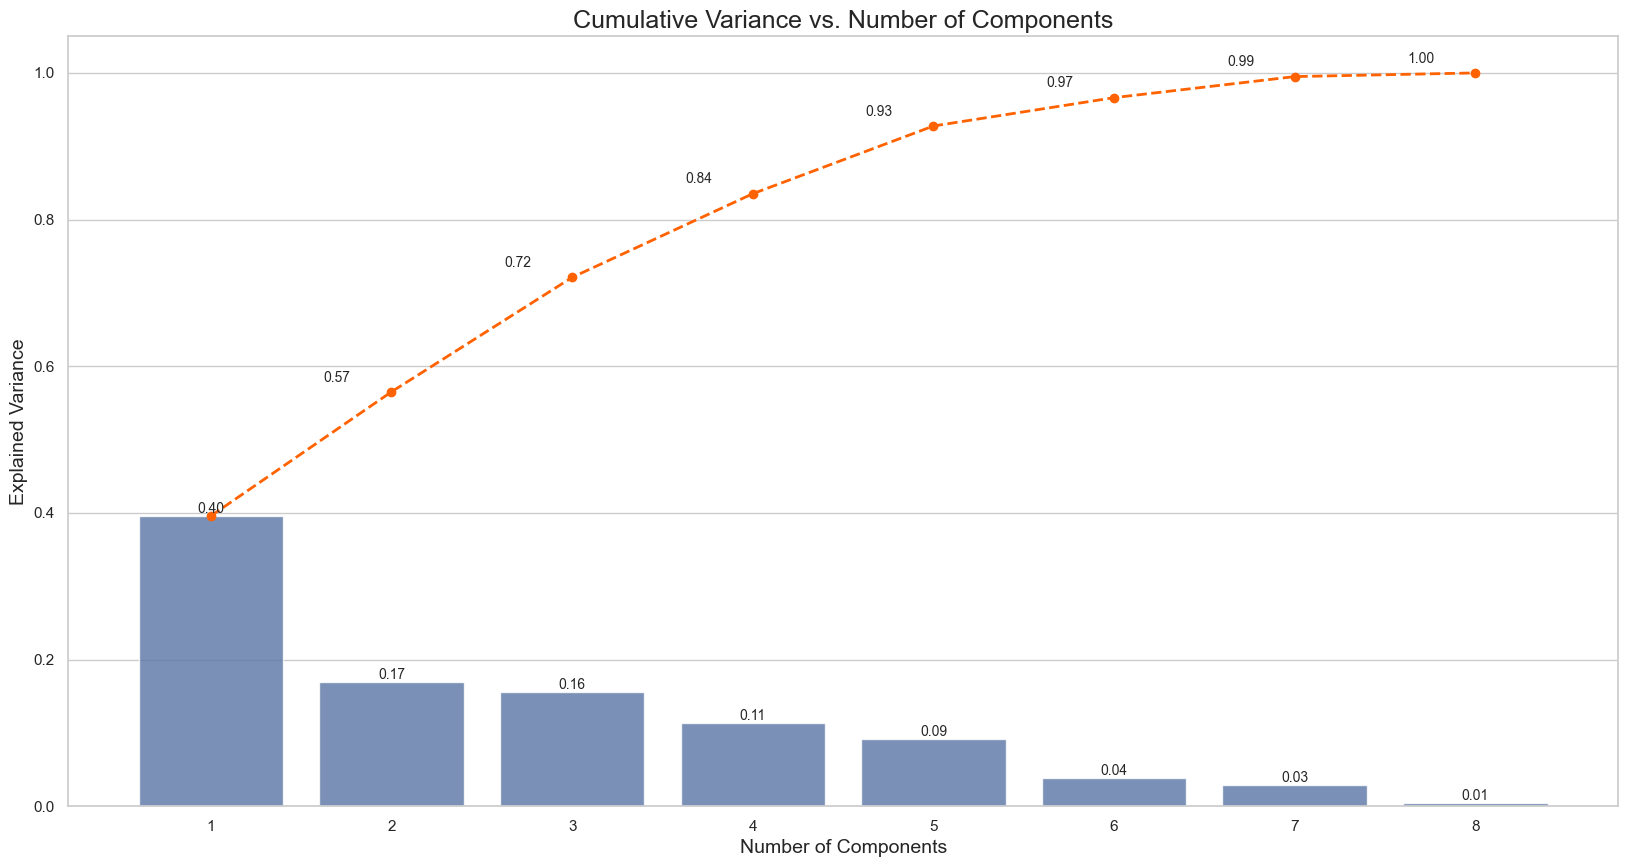

In [66]:
#Apply PCA
pca = PCA().fit(data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
sns.set(rc={'axes.facecolor': '#ffffff'}, style='whitegrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      # color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)


Upon analysing the cumulative explained variance, it was observed that:

* The first component explains approximately 43% of the variance.
* The second component increases the cumulative explained variance to around 62%.
* The third component brings the cumulative explained variance to 75%.
* The fourth component increases this to around 86%.
* The fifth component brings the cumulative explained variance to 93%. 
<br/>

After the fifth component, the additional variance explained by each subsequent component starts to diminish significantly. This can be seen as the cumulative variance curve begins to plateau, indicating that the subsequent components contribute only marginally to the total explained variance.

Selecting the first five principal components allows us to retain 93% of the variance in the data, while discarding components that contribute minimally to explaining additional variance. 

In [68]:
pca = PCA(n_components=5)
customer_data_pca = pca.fit_transform(data_scaled)
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])
customer_data_pca.index = data_scaled.index

In [69]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

PC1       PC2       PC3       PC4       PC5
Customer ID                                                  
12346.0     -0.988905  0.992081 -0.328103 -1.059412  0.150059
12347.0      1.651911 -0.768251  0.533509  0.265540 -0.891691
12348.0     -0.615789 -0.047680  0.971404  0.028836 -0.201297
12349.0      1.920235  0.456991  0.186442 -0.160201  0.036899
12350.0     -1.378924 -0.510380 -0.409687  0.332189  0.082876

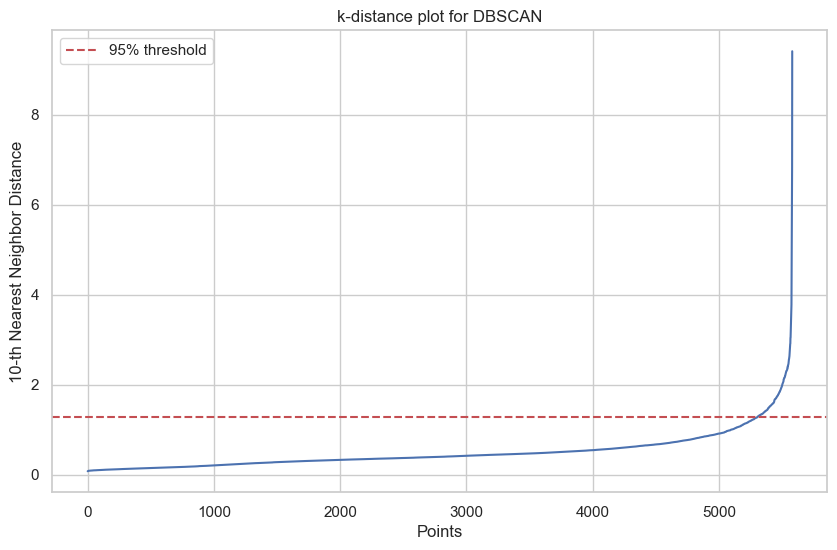

In [70]:
MinPts = 10  

# Step 2: Fit the Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(customer_data_pca)
distances, indices = neighbors_fit.kneighbors(customer_data_pca)

# Step 3: Sort the distances of the k-th nearest neighbors (MinPts-th)
# We use [:, MinPts-1] because the array is zero-indexed
distances = np.sort(distances[:, MinPts-1], axis=0)

# Step 4: Plot the k-distance curve
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.axhline(y=np.percentile(distances, 95), color='r', linestyle='--', label="95% threshold")
plt.title('k-distance plot for DBSCAN')
plt.xlabel('Points')
plt.ylabel(f'{MinPts}-th Nearest Neighbor Distance')
plt.grid(True)
plt.legend()
plt.show()

In [71]:
db = DBSCAN(eps=0.4, min_samples=13)
db.fit(customer_data_pca)

# Add cluster labels to the DataFrame
cluster_labels = db.labels_

data_rfm['Cluster'] = cluster_labels
customer_data_pca['Cluster'] = cluster_labels
data_rfm.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean', 'count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
-1        162.0     165.0        2856.0  2294
 0        239.0      52.0         704.0  3238
 1         61.0     252.0        2170.0    40
 2         16.0     143.0        2369.0     9

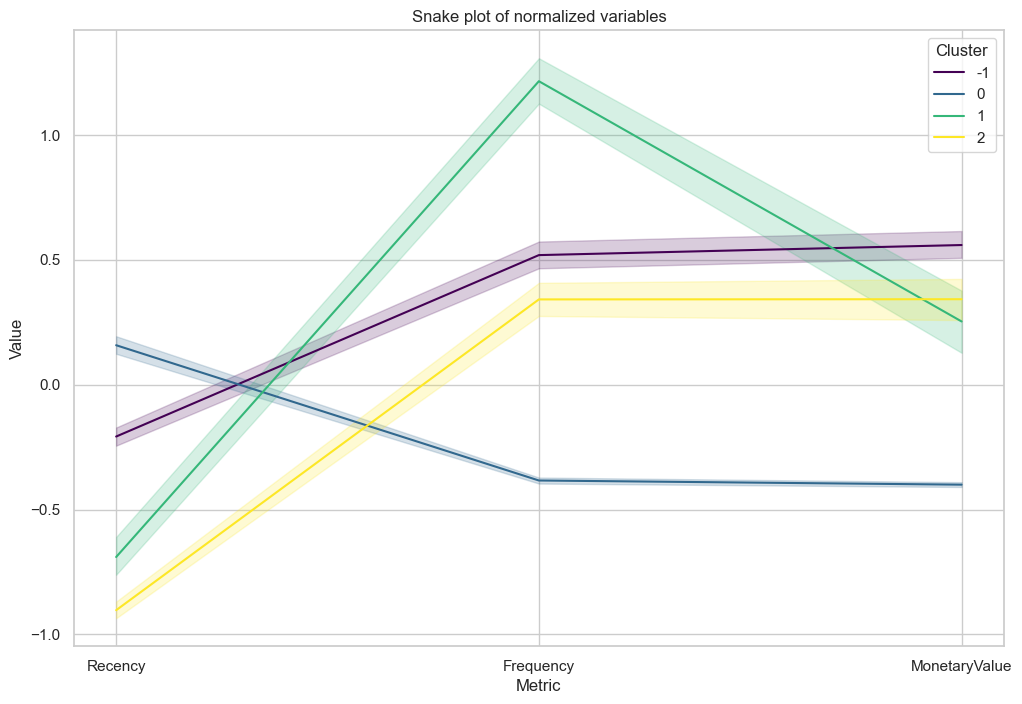

In [72]:
data_scaled['Cluster'] = cluster_labels  # Add cluster labels to the scaled data
data_scaled['Customer ID'] = data_rfm['Customer ID']

# Reset index and melt the DataFrame for the snake plot
rfm_melt = pd.melt(data_scaled.reset_index(drop=True), 
                   id_vars=['Customer ID', 'Cluster'],
                   value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                   var_name='Metric', value_name='Value')

# Step 6: Plot the snake plot
plt.figure(figsize=(12, 8))
plt.title('Snake plot of normalized variables')
sns.lineplot(data=rfm_melt, x='Metric', y='Value', hue='Cluster', palette='viridis')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Cluster')
plt.show()

The highlighted thickness of each of the line represents the standard deviation around the mean value for each cluster at each metric, showing the variabality of the data points within the cluster.

In [74]:
# custom_palette = px.colors.qualitative.Vivid

# fig = px.scatter_3d(customer_data_pca, x='PC1', y='PC2', z='PC3', color='Cluster', symbol='Cluster',
#                     title='3D PCA Clusters', color_discrete_sequence=custom_palette)

# fig.update_traces(marker=dict(size=5, symbol='circle', opacity=0.5), selector=dict(mode='markers'))

# fig.update_layout(scene=dict(
#     xaxis_title='PC1',
#     yaxis_title='PC2',
#     zaxis_title='PC3'
#     ),
#     width=800,  
#     height=600)

# fig.show()

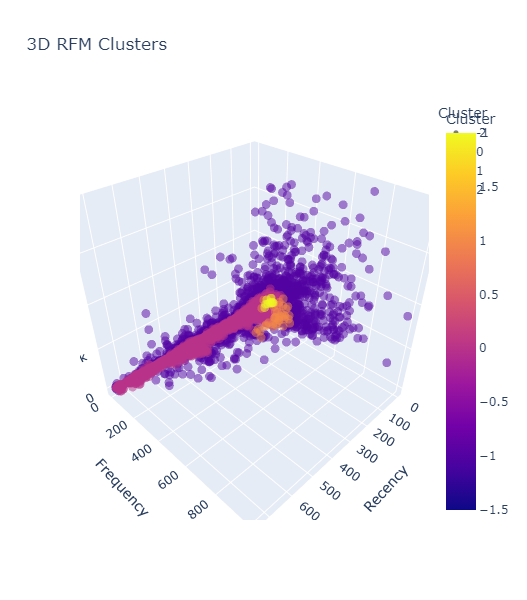

In [75]:
custom_palette = px.colors.qualitative.Vivid

fig = px.scatter_3d(data_rfm, x='Recency', y='Frequency', z='MonetaryValue', color='Cluster', symbol='Cluster',
                    title='3D RFM Clusters', color_discrete_sequence=custom_palette)

fig.update_traces(marker=dict(size=5, symbol='circle', opacity=0.5), selector=dict(mode='markers'))

fig.update_layout(scene=dict(
    xaxis_title='Recency',
    yaxis_title='Frequency',
    zaxis_title='MonetaryValue'
    ),
    width=800,  
    height=600)

fig.show()

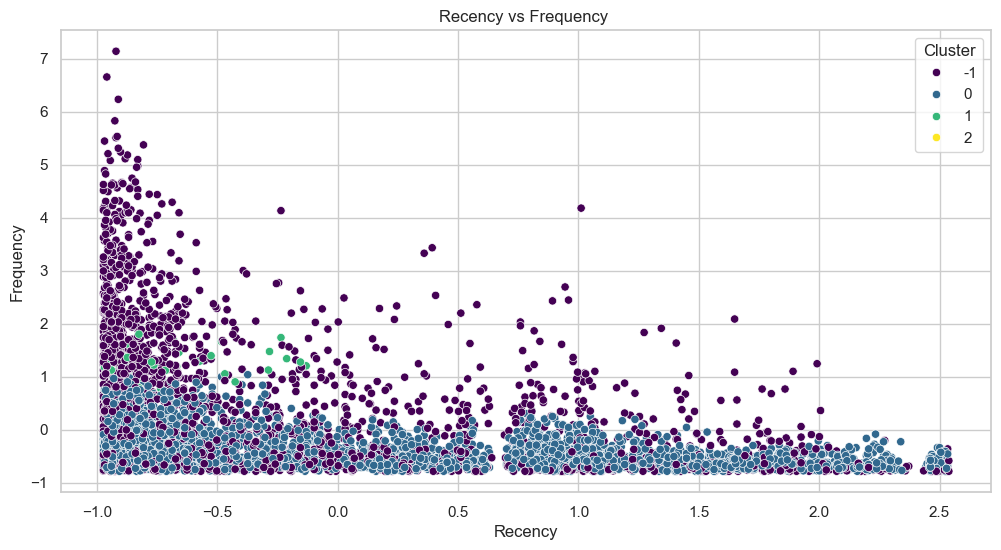

In [76]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data_scaled, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Recency vs Frequency ')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

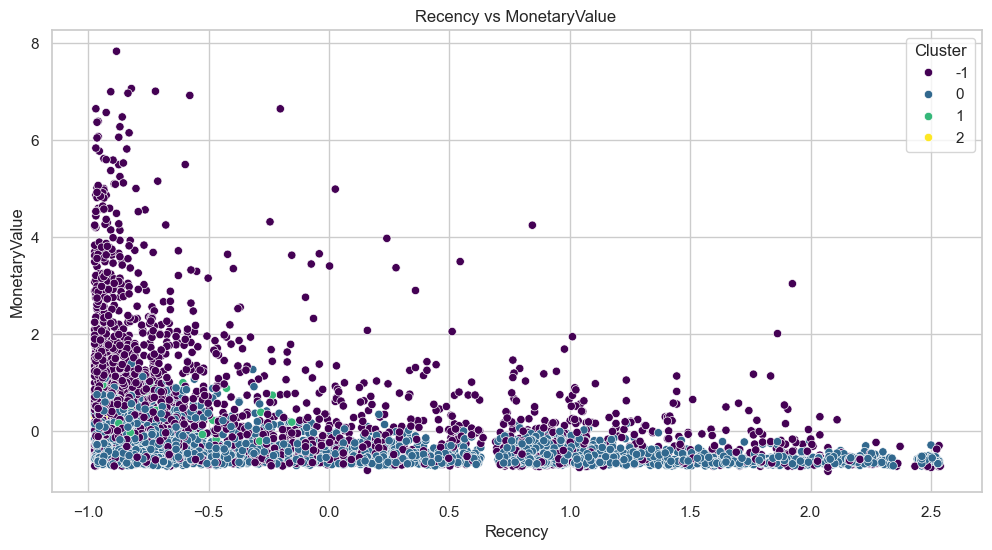

In [77]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data_scaled, x='Recency', y='MonetaryValue', hue='Cluster', palette='viridis')
plt.title('Recency vs MonetaryValue ')
plt.xlabel('Recency')
plt.ylabel('MonetaryValue')
plt.legend(title='Cluster')
plt.show()

In [78]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tabulate import tabulate

num_observations = len(customer_data_pca)
silhouette_avg = silhouette_score(customer_data_pca, cluster_labels)
db_index = davies_bouldin_score(customer_data_pca, cluster_labels)

data_metrics = [
    ["No. of Observations", num_observations],
    ["Silhouette Score", silhouette_avg],
    ["Davies Bouldin Score", db_index]
]

# Convert the data into a pandas DataFrame
print(tabulate(data_metrics, headers=["Metric", "Value"], tablefmt='pretty'))

+----------------------+---------------------+
|        Metric        |        Value        |
+----------------------+---------------------+
| No. of Observations  |        5581         |
|   Silhouette Score   | 0.08397253484769407 |
| Davies Bouldin Score | 1.5390537917774478  |
+----------------------+---------------------+


## Visualising the distribution of customers across the clusters

In [80]:
cluster_group = data_rfm.groupby(['Cluster'])

for cluster, group in cluster_group:
    print(f'\nCluster {cluster}:')
    print(group[['Recency','Frequency', 'MonetaryValue']].describe())


Cluster (-1,):
           Recency    Frequency  MonetaryValue
count  2294.000000  2294.000000    2294.000000
mean    161.901918   164.951177    2855.993967
std     188.180346   166.053043    2976.005499
min       1.000000     1.000000    -242.700000
25%      18.000000    30.000000     747.077500
50%      66.000000   111.000000    1896.685000
75%     268.000000   253.000000    3963.012500
max     739.000000   997.000000   19159.290000

Cluster (0,):
           Recency    Frequency  MonetaryValue
count  3238.000000  3238.000000    3238.000000
mean    238.737183    51.579061     704.024169
std     219.618052    45.206912     681.217445
min       1.000000     1.000000       0.000000
25%      38.000000    18.000000     232.987500
50%     165.000000    38.000000     467.750000
75%     411.000000    71.000000     943.257500
max     738.000000   260.000000    4838.180000

Cluster (1,):
         Recency   Frequency  MonetaryValue
count   40.00000   40.000000      40.000000
mean    60.52500  25

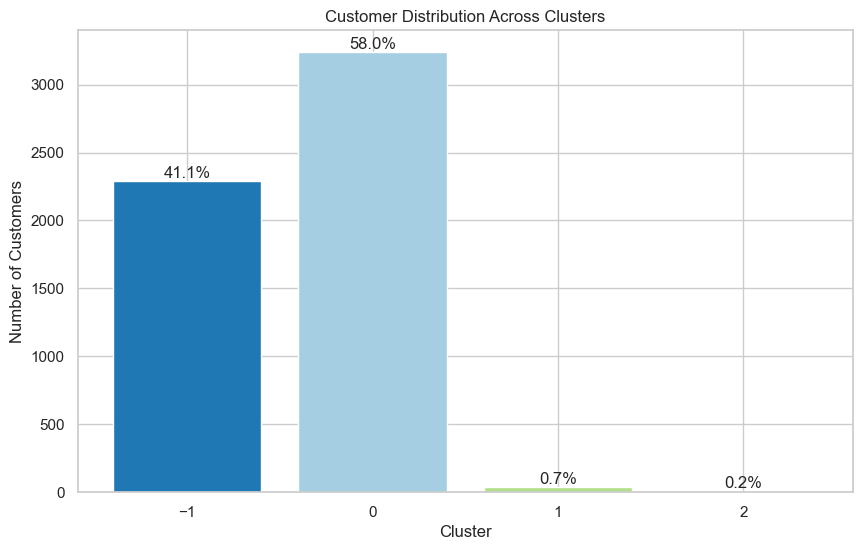

In [81]:
cluster_counts = data_scaled['Cluster'].value_counts()

# Create a bar plot for this distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.Paired.colors)

for bar in bars:
    yval = bar.get_height()
    percentage = f'{(yval / cluster_counts.sum()) * 100:.1f}%'
    plt.text(bar.get_x() + bar.get_width()/2, yval, percentage, ha='center', va='bottom')
    
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution Across Clusters')
plt.xticks(cluster_counts.index)
plt.show()

## Calculating Relative importance of RFM values in each cluster

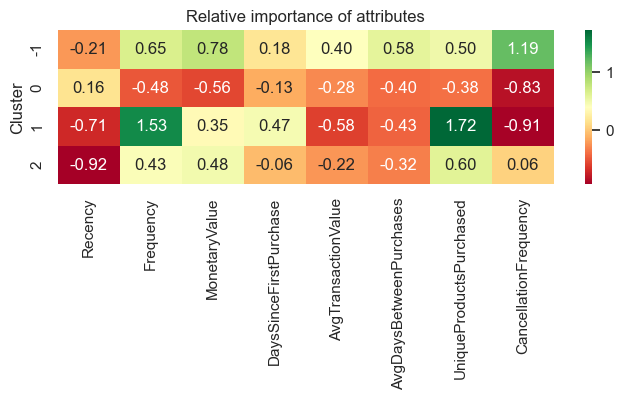

In [83]:
cluster_avg = data_rfm.drop(columns=['Customer ID']).groupby('Cluster').mean()

# Calcubblate the population average for the entire dataset excluding 'Cluster' and 'Customer ID'
population_avg = data_rfm.drop(columns=['Cluster', 'Customer ID']).mean()

# Calculate the relative importance
relative_imp = cluster_avg / population_avg - 1

# Plot the relative importance as a heatmap
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

# Second phase for neural networks

In [150]:
# data_scaled_nn = data_scaled[data_scaled['Cluster'] != -1]
# customer_data_pca_nn = customer_data_pca[customer_data_pca['Cluster'] != -1]

data_nn = data_rfm[data_rfm['Cluster'] != -1].copy()

# Extract features (excluding 'Customer ID' and 'Cluster')
X = data_nn.drop(columns=['Customer ID', 'Cluster']).values

# Extract labels (Cluster column)
y = data_nn['Cluster'].values

num_classes = len(np.unique(y))

# Step 2: Convert the labels to one-hot encoding
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

# Now X and y_encoded are ready to be used for training
print(f"Shape of X: {X.shape}")
print(f"Shape of y_encoded: {y_encoded.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_classes, activation='softmax')  

# First Dense layer
model.add(Dense(64, kernel_regularizer=l2(0.03), input_shape=(X.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Second Dense layer
model.add(Dense(32, kernel_regularizer=l2(0.03)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Third Dense layer
model.add(Dense(16, kernel_regularizer=l2(0.03)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitors the validation loss
    patience=3,                # Number of epochs with no improvement after which training will be stopped
    # restore_best_weights=True  # Restores the model weights from the epoch with the best validation loss
)
# Train the model with class weights
class_weights = {0: 0.34, 1: 27.39, 2: 121.37}  
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights,  callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Shape of X: (3287, 8)
Shape of y_encoded: (3287, 3)
Epoch 1/20
83/83 [==============================] - 2s 11ms/step - loss: 2.8280 - accuracy: 0.3423 - val_loss: 3.1859 - val_accuracy: 0.3739
Epoch 2/20
83/83 [==============================] - 1s 8ms/step - loss: 2.1228 - accuracy: 0.8174 - val_loss: 2.4341 - val_accuracy: 0.8024
Epoch 3/20
83/83 [==============================] - 1s 8ms/step - loss: 1.7879 - accuracy: 0.8722 - val_loss: 2.0922 - val_accuracy: 0.8419
Epoch 4/20
83/83 [==============================] - 1s 8ms/step - loss: 1.5127 - accuracy: 0.8962 - val_loss: 1.6633 - val_accuracy: 0.8951
Epoch 5/20
83/83 [==============================] - 1s 8ms/step - loss: 1.3150 - accuracy: 0.8886 - val_loss: 1.3130 - val_accuracy: 0.9468
Epoch 6/20
83/83 [==============================] - 1s 8ms/step - loss: 1.2198 - accuracy: 0.9068 - val_loss: 1.1977 - val_accuracy: 0.9438
Epoch 7/20
83/83 [==============================] - 1s 7ms/step - loss: 1.1116 - accuracy: 0.8859 - val_los

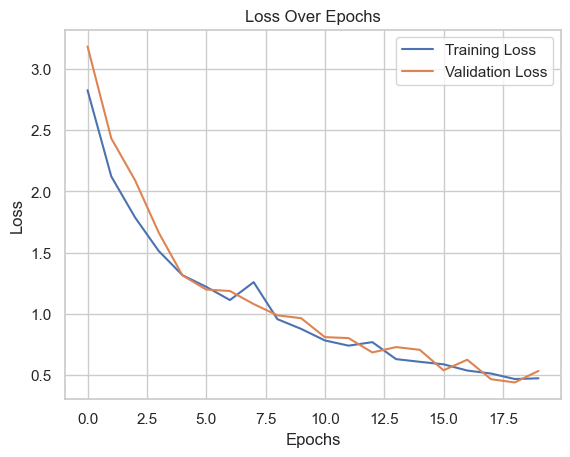

21/21 [==============================] - 0s 2ms/step


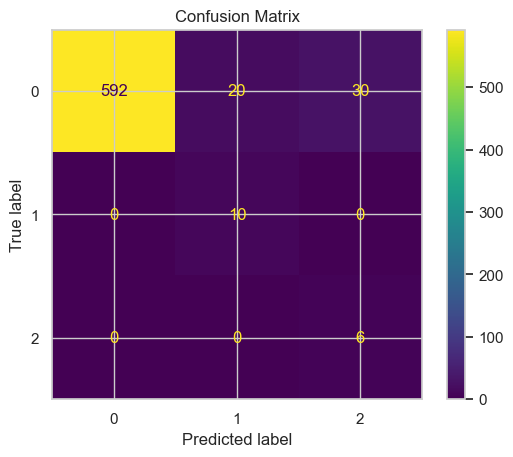

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       642
           1       0.33      1.00      0.50        10
           2       0.17      1.00      0.29         6

    accuracy                           0.92       658
   macro avg       0.50      0.97      0.58       658
weighted avg       0.98      0.92      0.95       658

21/21 [==============================] - 0s 4ms/step - loss: 0.5319 - accuracy: 0.9240
Test Accuracy: 0.9240


In [154]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1)  

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')